# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=79,
        fold=1,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_19-39-04/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4952 | MulticlassF1Score=0.1291
Batch-30 : CrossEntropyLoss=2.4954 | MulticlassF1Score=0.1923
Batch-45 : CrossEntropyLoss=2.4681 | MulticlassF1Score=0.2287
Batch-60 : CrossEntropyLoss=2.4688 | MulticlassF1Score=0.2465
Batch-75 : CrossEntropyLoss=2.4616 | MulticlassF1Score=0.2581
Batch-90 : CrossEntropyLoss=2.4284 | MulticlassF1Score=0.2754
Batch-105: CrossEntropyLoss=2.4236 | MulticlassF1Score=0.3005
Batch-120: CrossEntropyLoss=2.4224 | MulticlassF1Score=0.3215
Batch-135: CrossEntropyLoss=2.4086 | MulticlassF1Score=0.3384
Batch-150: CrossEntropyLoss=2.3763 | MulticlassF1Score=0.3555
Batch-165: CrossEntropyLoss=2.3609 | MulticlassF1Score=0.3757
Batch-180: CrossEntropyLoss=2.3756 | MulticlassF1Score=0.3929
Batch-195: CrossEntropyLoss=2.3587 | MulticlassF1Score=0.4095
Batch-210: CrossEntropyLoss=2.3502 | MulticlassF1Score=0.4267
Batch-225: CrossEntropyLoss=2.3588 | MulticlassF1Score=0.4422
Batch-226: CrossEntropyLoss=2.3833 | MulticlassF1Score=0.4430

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3584 | MulticlassF1Score=0.6640
Batch-30 : CrossEntropyLoss=2.3438 | MulticlassF1Score=0.6667
Batch-45 : CrossEntropyLoss=2.3511 | MulticlassF1Score=0.6672
Batch-60 : CrossEntropyLoss=2.3399 | MulticlassF1Score=0.6675
Batch-63 : CrossEntropyLoss=2.3725 | MulticlassF1Score=0.6665

Training   : Mean CrossEntropyLoss = 2.4298 | Mean MulticlassF1Score = 0.3015
Validation : Mean CrossEntropyLoss = 2.3532 | Mean MulticlassF1Score = 0.6646

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3595 | MulticlassF1Score=0.6633
Batch-30 : CrossEntropyLoss=2.3619 | MulticlassF1Score=0.6698
Batch-45 : CrossEntropyLoss=2.3510 | MulticlassF1Score=0.6726
Batch-60 : CrossEntropyLoss=2.3514 | MulticlassF1Score=0.6731
Batch-75 : CrossEntropyLoss=2.3566 | MulticlassF1Score=0.6743
Batch-90 : CrossEntropyLoss=2.3399 | MulticlassF1Score=0.6750
Batch-105: CrossEntropyLoss=2.3556 | MulticlassF1Score=0.6755
Batch-120: CrossEntropyLoss=2.3543 | MulticlassF1Score=0.6774
Batch-135: CrossEntropyLoss=2.3325 | MulticlassF1Score=0.6815
Batch-150: CrossEntropyLoss=2.3467 | MulticlassF1Score=0.6850
Batch-165: CrossEntropyLoss=2.3299 | MulticlassF1Score=0.6899
Batch-180: CrossEntropyLoss=2.3189 | MulticlassF1Score=0.6970
Batch-195: CrossEntropyLoss=2.3214 | MulticlassF1Score=0.7036
Batch-210: CrossEntropyLoss=2.3130 | MulticlassF1Score=0.7093
Batch-225: CrossEntropyLoss=2.3178 | MulticlassF1Score=0.7140
Batch-226: CrossEntropyLoss=2.3139 | MulticlassF1Score=0.7142

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3121 | MulticlassF1Score=0.7931
Batch-30 : CrossEntropyLoss=2.3072 | MulticlassF1Score=0.7917
Batch-45 : CrossEntropyLoss=2.3207 | MulticlassF1Score=0.7900
Batch-60 : CrossEntropyLoss=2.3102 | MulticlassF1Score=0.7875
Batch-63 : CrossEntropyLoss=2.3135 | MulticlassF1Score=0.7874

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3371 | Mean MulticlassF1Score = 0.6828
Validation : Mean CrossEntropyLoss = 2.3148 | Mean MulticlassF1Score = 0.7896

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3152 | MulticlassF1Score=0.7899
Batch-30 : CrossEntropyLoss=2.3163 | MulticlassF1Score=0.7916
Batch-45 : CrossEntropyLoss=2.3092 | MulticlassF1Score=0.7923
Batch-60 : CrossEntropyLoss=2.3140 | MulticlassF1Score=0.7911
Batch-75 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.7906
Batch-90 : CrossEntropyLoss=2.3161 | MulticlassF1Score=0.7912
Batch-105: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.7913
Batch-120: CrossEntropyLoss=2.3044 | MulticlassF1Score=0.7909
Batch-135: CrossEntropyLoss=2.3140 | MulticlassF1Score=0.7913
Batch-150: CrossEntropyLoss=2.3169 | MulticlassF1Score=0.7912
Batch-165: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.7913
Batch-180: CrossEntropyLoss=2.3104 | MulticlassF1Score=0.7917
Batch-195: CrossEntropyLoss=2.3086 | MulticlassF1Score=0.7913
Batch-210: CrossEntropyLoss=2.3153 | MulticlassF1Score=0.7921
Batch-225: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.7936
Batch-226: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.7937

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3124 | MulticlassF1Score=0.8081
Batch-30 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8095
Batch-45 : CrossEntropyLoss=2.3099 | MulticlassF1Score=0.8111
Batch-60 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8105
Batch-63 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8109

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3120 | Mean MulticlassF1Score = 0.7913
Validation : Mean CrossEntropyLoss = 2.3071 | Mean MulticlassF1Score = 0.8081

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3113 | MulticlassF1Score=0.8213
Batch-30 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8158
Batch-45 : CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8147
Batch-60 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8182
Batch-75 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8198
Batch-90 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8212
Batch-105: CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8213
Batch-120: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8225
Batch-135: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8222
Batch-150: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8223
Batch-165: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8221
Batch-180: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8224
Batch-195: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8232
Batch-210: CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8241
Batch-225: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8248
Batch-226: CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8248

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8289
Batch-30 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8295
Batch-45 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8309
Batch-60 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8334
Batch-63 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8337

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3022 | Mean MulticlassF1Score = 0.8211
Validation : Mean CrossEntropyLoss = 2.2997 | Mean MulticlassF1Score = 0.8303

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8452
Batch-30 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8384
Batch-45 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8393
Batch-60 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8369
Batch-75 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8372
Batch-90 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8365
Batch-105: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8358
Batch-120: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8364
Batch-135: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8364
Batch-150: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8365
Batch-165: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8365
Batch-180: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8367
Batch-195: CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8367
Batch-210: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8369
Batch-225: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8372
Batch-226: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8373

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8377
Batch-30 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8347
Batch-45 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8339
Batch-60 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8346
Batch-63 : CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8340

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2981 | Mean MulticlassF1Score = 0.8376
Validation : Mean CrossEntropyLoss = 2.2995 | Mean MulticlassF1Score = 0.8357

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8445
Batch-30 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8428
Batch-45 : CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8423
Batch-60 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8409
Batch-75 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8415
Batch-90 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8391
Batch-105: CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8386
Batch-120: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8388
Batch-135: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8382
Batch-150: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8387
Batch-165: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8390
Batch-180: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8396
Batch-195: CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8390
Batch-210: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8393
Batch-225: CrossEntropyLoss=2.3127 | MulticlassF1Score=0.8393
Batch-226: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8393

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8353
Batch-30 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8341
Batch-45 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8365
Batch-60 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8340
Batch-63 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8342

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2974 | Mean MulticlassF1Score = 0.8403
Validation : Mean CrossEntropyLoss = 2.2992 | Mean MulticlassF1Score = 0.8344

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8460
Batch-30 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8436
Batch-45 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8414
Batch-60 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8429
Batch-75 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8420
Batch-90 : CrossEntropyLoss=2.3086 | MulticlassF1Score=0.8407
Batch-105: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8404
Batch-120: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8404
Batch-135: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8405
Batch-150: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8403
Batch-165: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8406
Batch-180: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8412
Batch-195: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8410
Batch-210: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8410
Batch-225: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8410
Batch-226: CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8408

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8393
Batch-30 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8377
Batch-45 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8380
Batch-60 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8360
Batch-63 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8365

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2968 | Mean MulticlassF1Score = 0.8417
Validation : Mean CrossEntropyLoss = 2.2985 | Mean MulticlassF1Score = 0.8380

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8448
Batch-30 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8419
Batch-45 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8426
Batch-60 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8437
Batch-75 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8429
Batch-90 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8429
Batch-105: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8425
Batch-120: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8419
Batch-135: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8419
Batch-150: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8419
Batch-165: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8422
Batch-180: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8429
Batch-195: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8426
Batch-210: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8423
Batch-225: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8422
Batch-226: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8422

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8381
Batch-30 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8366
Batch-45 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8369
Batch-60 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8367
Batch-63 : CrossEntropyLoss=2.3100 | MulticlassF1Score=0.8365

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2964 | Mean MulticlassF1Score = 0.8427
Validation : Mean CrossEntropyLoss = 2.2986 | Mean MulticlassF1Score = 0.8369

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8411
Batch-30 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8446
Batch-45 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8438
Batch-60 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8440
Batch-75 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8436
Batch-90 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8449
Batch-105: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8450
Batch-120: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8448
Batch-135: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8442
Batch-150: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8439
Batch-165: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8434
Batch-180: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8427
Batch-195: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8432
Batch-210: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8434
Batch-225: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8430
Batch-226: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8431

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8415
Batch-30 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8367
Batch-45 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8385
Batch-60 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8368
Batch-63 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8366

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2961 | Mean MulticlassF1Score = 0.8442
Validation : Mean CrossEntropyLoss = 2.2985 | Mean MulticlassF1Score = 0.8388

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8498
Batch-30 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8454
Batch-45 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8453
Batch-60 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8429
Batch-75 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8460
Batch-90 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8483
Batch-105: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8506
Batch-120: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8520
Batch-135: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8535
Batch-150: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8540
Batch-165: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8543
Batch-180: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8547
Batch-195: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8555
Batch-210: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8554
Batch-225: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8560
Batch-226: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8561

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8522
Batch-30 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8537
Batch-45 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8538
Batch-60 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8555
Batch-63 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8560

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2923 | Mean MulticlassF1Score = 0.8508
Validation : Mean CrossEntropyLoss = 2.2927 | Mean MulticlassF1Score = 0.8533

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8578
Batch-30 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8586
Batch-45 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8608
Batch-60 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8617
Batch-75 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8618
Batch-90 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8625
Batch-105: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8636
Batch-120: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8631
Batch-135: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8633
Batch-150: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8636
Batch-165: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8634
Batch-180: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8637
Batch-195: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8640
Batch-210: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8640
Batch-225: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8638
Batch-226: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8638

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8615
Batch-30 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8563
Batch-45 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8552
Batch-60 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8558
Batch-63 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8559

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2898 | Mean MulticlassF1Score = 0.8623
Validation : Mean CrossEntropyLoss = 2.2926 | Mean MulticlassF1Score = 0.8573

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8688
Batch-30 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8660
Batch-45 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8651
Batch-60 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8651
Batch-75 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8656
Batch-90 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8655
Batch-105: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8657
Batch-120: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8656
Batch-135: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8662
Batch-150: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8662
Batch-165: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8662
Batch-180: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8657
Batch-195: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8659
Batch-210: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8657
Batch-225: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8656
Batch-226: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8657

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8528
Batch-30 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8550
Batch-45 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8579
Batch-60 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8573
Batch-63 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8582

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2892 | Mean MulticlassF1Score = 0.8659
Validation : Mean CrossEntropyLoss = 2.2918 | Mean MulticlassF1Score = 0.8551

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8617
Batch-30 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8671
Batch-45 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8648
Batch-60 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8654
Batch-75 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8661
Batch-90 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8669
Batch-105: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8672
Batch-120: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8669
Batch-135: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8669
Batch-150: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8666
Batch-165: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8663
Batch-180: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8669
Batch-195: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8672
Batch-210: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8671
Batch-225: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8673
Batch-226: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8673

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8542
Batch-30 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8548
Batch-45 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8572
Batch-60 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8584
Batch-63 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8584

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2886 | Mean MulticlassF1Score = 0.8665
Validation : Mean CrossEntropyLoss = 2.2917 | Mean MulticlassF1Score = 0.8552

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8586
Batch-30 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8665
Batch-45 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8725
Batch-60 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8772
Batch-75 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8797
Batch-90 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8810
Batch-105: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.8847
Batch-120: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.8886
Batch-135: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.8915
Batch-150: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8945
Batch-165: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8962
Batch-180: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.8978
Batch-195: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.8994
Batch-210: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9007
Batch-225: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9025
Batch-226: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9026

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9125
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9136
Batch-45 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9131
Batch-60 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9127
Batch-63 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9125

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2781 | Mean MulticlassF1Score = 0.8851
Validation : Mean CrossEntropyLoss = 2.2753 | Mean MulticlassF1Score = 0.9133

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9197
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9189
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9200
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9214
Batch-75 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9224
Batch-90 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9225
Batch-105: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9233
Batch-120: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9234
Batch-135: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9233
Batch-150: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9236
Batch-165: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9238
Batch-180: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9233
Batch-195: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9236
Batch-210: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9235
Batch-225: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9237
Batch-226: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9237

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9082
Batch-30 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.9139
Batch-45 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9144
Batch-60 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9150
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9152

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9221
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9121

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9287
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9271
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9274
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9274
Batch-75 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9274
Batch-90 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9272
Batch-105: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9273
Batch-120: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9274
Batch-135: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9268
Batch-150: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9273
Batch-165: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9275
Batch-180: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9274
Batch-195: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9273
Batch-210: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9270
Batch-225: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9269
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9269

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9152
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9191
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9178
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9170
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9168

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9272
Validation : Mean CrossEntropyLoss = 2.2737 | Mean MulticlassF1Score = 0.9178

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9261
Batch-30 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9262
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9262
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9281
Batch-75 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9278
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9286
Batch-105: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9285
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9292
Batch-135: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9289
Batch-150: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9286
Batch-165: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9290
Batch-180: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9289
Batch-195: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9291
Batch-210: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9288
Batch-225: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9290
Batch-226: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9290

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9204
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9193
Batch-45 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9186
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9186
Batch-63 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9188

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9281
Validation : Mean CrossEntropyLoss = 2.2730 | Mean MulticlassF1Score = 0.9188

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9339
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9326
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9337
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9332
Batch-75 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9327
Batch-90 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9324
Batch-105: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9335
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9334
Batch-135: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9334
Batch-150: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9333
Batch-165: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9329
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9329
Batch-195: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9333
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9335
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9335
Batch-226: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9335

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9217
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9208
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9221
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9223
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9228

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2683 | Mean MulticlassF1Score = 0.9331
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9219

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9363
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9351
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9367
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9363
Batch-75 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9372
Batch-90 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9364
Batch-105: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9354
Batch-120: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9356
Batch-135: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9355
Batch-150: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9359
Batch-165: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9362
Batch-180: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9360
Batch-195: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9359
Batch-210: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9361
Batch-225: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9362
Batch-226: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9362

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9238
Batch-30 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9221
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9222
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9221
Batch-63 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9220

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9360
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9236

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9397
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9404
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9389
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9386
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9393
Batch-90 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9384
Batch-105: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9384
Batch-120: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9372
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9372
Batch-150: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9372
Batch-165: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9373
Batch-180: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9374
Batch-195: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9372
Batch-210: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9370
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9370
Batch-226: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9370

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9229
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9222
Batch-45 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9221
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9224
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9228

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9381
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9223

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9375
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9385
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9388
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9390
Batch-75 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9387
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9381
Batch-105: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9380
Batch-120: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9379
Batch-135: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9383
Batch-150: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9382
Batch-165: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9382
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9382
Batch-195: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9381
Batch-210: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9380
Batch-225: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9382
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9383

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9220
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9237
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9240
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9233
Batch-63 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9238

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9383
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9239

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9380
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9399
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9395
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9397
Batch-75 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9402
Batch-90 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9405
Batch-105: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9401
Batch-120: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9407
Batch-135: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9402
Batch-150: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9400
Batch-165: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9400
Batch-180: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9399
Batch-195: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9398
Batch-210: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9394
Batch-225: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9392
Batch-226: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9392

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9275
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9245
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9248
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9239
Batch-63 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9235

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9402
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9249

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9379
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9385
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9381
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9381
Batch-75 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9385
Batch-90 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9382
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9387
Batch-120: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9392
Batch-135: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9391
Batch-150: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9390
Batch-165: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9391
Batch-180: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9389
Batch-195: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9391
Batch-210: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9394
Batch-225: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9394
Batch-226: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9393

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9283
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9249
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9241
Batch-60 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9233
Batch-63 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9234

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9388
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9251

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9427
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9410
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9416
Batch-75 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9414
Batch-90 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9414
Batch-105: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9413
Batch-120: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9412
Batch-135: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9408
Batch-150: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9405
Batch-165: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9406
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9406
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9403
Batch-210: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9403
Batch-225: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9405
Batch-226: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9404

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9245
Batch-45 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9225
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9236
Batch-63 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9234

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9413
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9238

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9443
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9415
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9408
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9408
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9413
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9417
Batch-120: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9413
Batch-135: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9412
Batch-150: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9415
Batch-165: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9412
Batch-180: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9412
Batch-195: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9411
Batch-210: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9411
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9411
Batch-226: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9411

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9162
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9202
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9215
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9224
Batch-63 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9230

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9415
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9191

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9399
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9420
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9411
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9412
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9414
Batch-90 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9417
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9422
Batch-120: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9421
Batch-135: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9423
Batch-150: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9421
Batch-165: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9418
Batch-180: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9417
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9415
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9415
Batch-225: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9415
Batch-226: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9415

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9220
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9250
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9244
Batch-63 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9235

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9416
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9231

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9417
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9429
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9435
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9431
Batch-75 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9425
Batch-90 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9421
Batch-105: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9418
Batch-120: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9414
Batch-135: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9413
Batch-150: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9413
Batch-165: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9413
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9413
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9415
Batch-210: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9416
Batch-225: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9416
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9417

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9208
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9246
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9241
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9229
Batch-63 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9230

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9422
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9218

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9425
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9416
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9420
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9423
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9424
Batch-90 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9426
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9427
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9421
Batch-135: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9421
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9419
Batch-165: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9415
Batch-180: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9413
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9414
Batch-210: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9413
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9413
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9414

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9213
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9215
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9231
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9235
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9234

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9419
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9212
Patience = 1/50❗

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9401
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9401
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9409
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9416
Batch-75 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9411
Batch-90 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9413
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9415
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9417
Batch-135: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9415
Batch-150: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9412
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9416
Batch-180: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9420
Batch-195: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9421
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9423
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9420
Batch-226: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9421

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9237
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9237
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9239
Batch-63 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9239

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9412
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9240

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9424
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9410
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9413
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9413
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9414
Batch-90 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9411
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9417
Batch-120: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9419
Batch-135: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9423
Batch-150: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9424
Batch-165: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9426
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9424
Batch-195: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9424
Batch-210: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9425
Batch-225: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9423
Batch-226: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9423

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9203
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9234
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9238
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9229
Batch-63 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9229

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9420
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9219

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9444
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9420
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9433
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9432
Batch-75 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9432
Batch-90 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9427
Batch-105: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9427
Batch-120: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9429
Batch-135: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9432
Batch-150: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9434
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9430
Batch-180: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9431
Batch-195: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9430
Batch-210: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9425
Batch-225: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9422
Batch-226: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9422

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9193
Batch-30 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9222
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9220
Batch-60 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9225
Batch-63 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9223

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9432
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9211
Patience = 2/50❗

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9443
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9414
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9404
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9399
Batch-75 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9387
Batch-90 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9382
Batch-105: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9389
Batch-120: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9392
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9394
Batch-150: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9397
Batch-165: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9395
Batch-180: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9400
Batch-195: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9399
Batch-210: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9399
Batch-225: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9398
Batch-226: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9398

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9255
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9246
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9235
Batch-63 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9237

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2688 | Mean MulticlassF1Score = 0.9404
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9250
Patience = 3/50❗

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9449
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9423
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9434
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9423
Batch-75 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9423
Batch-90 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9418
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9418
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9424
Batch-135: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9424
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9425
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9425
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9422
Batch-195: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9424
Batch-210: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9425
Batch-225: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9424
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9424

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9244
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9238
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9236
Batch-63 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9238

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9425
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9237

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9432
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9411
Batch-60 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9415
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9424
Batch-90 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9430
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9435
Batch-120: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9451
Batch-135: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9467
Batch-150: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9480
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9492
Batch-180: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9502
Batch-195: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9510
Batch-210: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9518
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9526
Batch-226: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9526

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9433
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9436
Batch-63 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9438

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2622 | Mean MulticlassF1Score = 0.9458
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9448

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9651
Batch-30 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9638
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9640
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9647
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9642
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9642
Batch-105: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9636
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9633
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9634
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9633
Batch-165: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9632
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9631
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9630
Batch-210: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9631
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9631
Batch-226: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9631

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9441
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9439

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2589 | Mean MulticlassF1Score = 0.9637
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9445

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9660
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9639
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9641
Batch-60 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9638
Batch-75 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9639
Batch-90 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9638
Batch-105: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9639
Batch-120: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9637
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9634
Batch-150: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9636
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9637
Batch-180: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9637
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9636
Batch-210: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9637
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9640
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9640

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9450
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9446
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9447

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9639
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9454

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9666
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9658
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9647
Batch-60 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9650
Batch-75 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9647
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9643
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9647
Batch-120: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9650
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9647
Batch-150: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9649
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9648
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9645
Batch-195: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9643
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9641
Batch-225: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9643
Batch-226: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9643

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9442
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9448
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9442
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9442
Batch-63 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9442

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9647
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9443

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9657
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9643
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9644
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9653
Batch-75 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9647
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9645
Batch-105: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9646
Batch-120: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9646
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9647
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9647
Batch-165: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9646
Batch-180: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9647
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9648
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9649
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9650
Batch-226: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9651

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9454
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9466
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9460
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9461

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9648
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9462

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9656
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9664
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9668
Batch-60 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9674
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9674
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9670
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9674
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9675
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9674
Batch-150: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9676
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9676
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9675
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9675
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9673
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9674
Batch-226: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9674

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9466

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9673
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9483

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9692
Batch-30 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9686
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9673
Batch-75 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9680
Batch-90 : CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9680
Batch-135: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9679
Batch-150: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9678
Batch-165: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9673
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9673
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9674
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9672
Batch-225: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9674
Batch-226: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9674

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9439
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9459
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9465
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9467

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9680
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9453

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9661
Batch-30 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9664
Batch-45 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9680
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9689
Batch-75 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2521 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9680
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9679
Batch-150: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9676
Batch-165: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9679
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9680
Batch-195: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9680
Batch-210: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9676
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9676

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9478

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9678
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9470

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9646
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9669
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9671
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9674
Batch-75 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9669
Batch-90 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9671
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9674
Batch-120: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9674
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9679
Batch-165: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9681
Batch-180: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9678
Batch-195: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9675
Batch-210: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9676
Batch-226: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9676

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9673
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9489

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9674
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9686
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9684
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9684
Batch-90 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9681
Batch-105: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9680
Batch-135: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9678
Batch-150: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9678
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9681
Batch-180: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9680
Batch-195: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9680
Batch-210: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9677
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9473

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9679
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9478
Patience = 4/50❗

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9678
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9660
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9669
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9669
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9672
Batch-90 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9677
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9676
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9675
Batch-135: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9676
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9677
Batch-180: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9676
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9675
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2521 | MulticlassF1Score=0.9677
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9672
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9467

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9650
Batch-30 : CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9665
Batch-45 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9672
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9673
Batch-90 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9673
Batch-105: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9678
Batch-120: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9682
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9676
Batch-150: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9678
Batch-165: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9678
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9680
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9680
Batch-210: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9680
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9680
Batch-226: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9680

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9470
Batch-30 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9480

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9673
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9486

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2508 | MulticlassF1Score=0.9741
Batch-30 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9715
Batch-45 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9710
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9702
Batch-75 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9699
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9696
Batch-105: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9694
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9695
Batch-135: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9695
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9694
Batch-165: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9687
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9685
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9685
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9684
Batch-226: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9684

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9497
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9475

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9699
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9480

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9655
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9663
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9666
Batch-60 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9670
Batch-75 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9678
Batch-90 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9676
Batch-105: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9678
Batch-120: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9682
Batch-150: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9680
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9678
Batch-180: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9678
Batch-195: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9681
Batch-210: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9684
Batch-225: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9682
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9506
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9483

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9674
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9486
Patience = 5/50❗

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9671
Batch-30 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9685
Batch-45 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9692
Batch-60 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9693
Batch-75 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9696
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9699
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9695
Batch-120: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9695
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9698
Batch-165: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9700
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9702
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9700
Batch-210: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9699
Batch-225: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9699
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9699

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9506
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9499
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9489

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9694
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9500

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9725
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9724
Batch-45 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9713
Batch-60 : CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9712
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9713
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9712
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9708
Batch-120: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9705
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9705
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9703
Batch-165: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9705
Batch-180: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9705
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9707
Batch-210: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9706
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9706
Batch-226: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9706

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9498
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9491
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9493
Batch-63 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9490

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9711
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9488

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9677
Batch-30 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9704
Batch-60 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9710
Batch-90 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9713
Batch-105: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9710
Batch-120: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9713
Batch-135: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9712
Batch-165: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9710
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9710
Batch-195: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9711
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9711
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9711
Batch-226: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9494
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9513
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9501
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9493
Batch-63 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9494

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9705
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9504

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2563
Best CrossEntropyLoss training    : 2.2632
Best MulticlassF1Score validation : 0.9705
Best MulticlassF1Score validation : 0.9504
Training duration                 : 2.0070 minutes.
Training date                     : 2022-10-19 14:42:45.406450+08:00


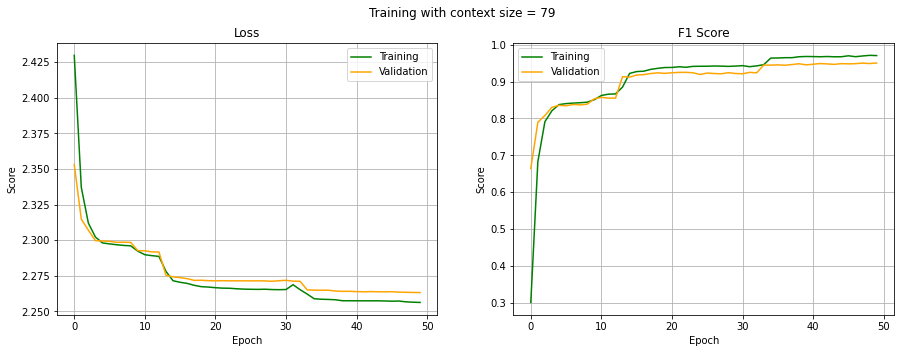

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9715, device='cuda:0'),
 tensor(0.9494, device='cuda:0'),
 tensor(0.9498, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9715, device='cuda:0'),
 tensor(0.9494, device='cuda:0'),
 tensor(0.9498, device='cuda:0'))

## Heatmap

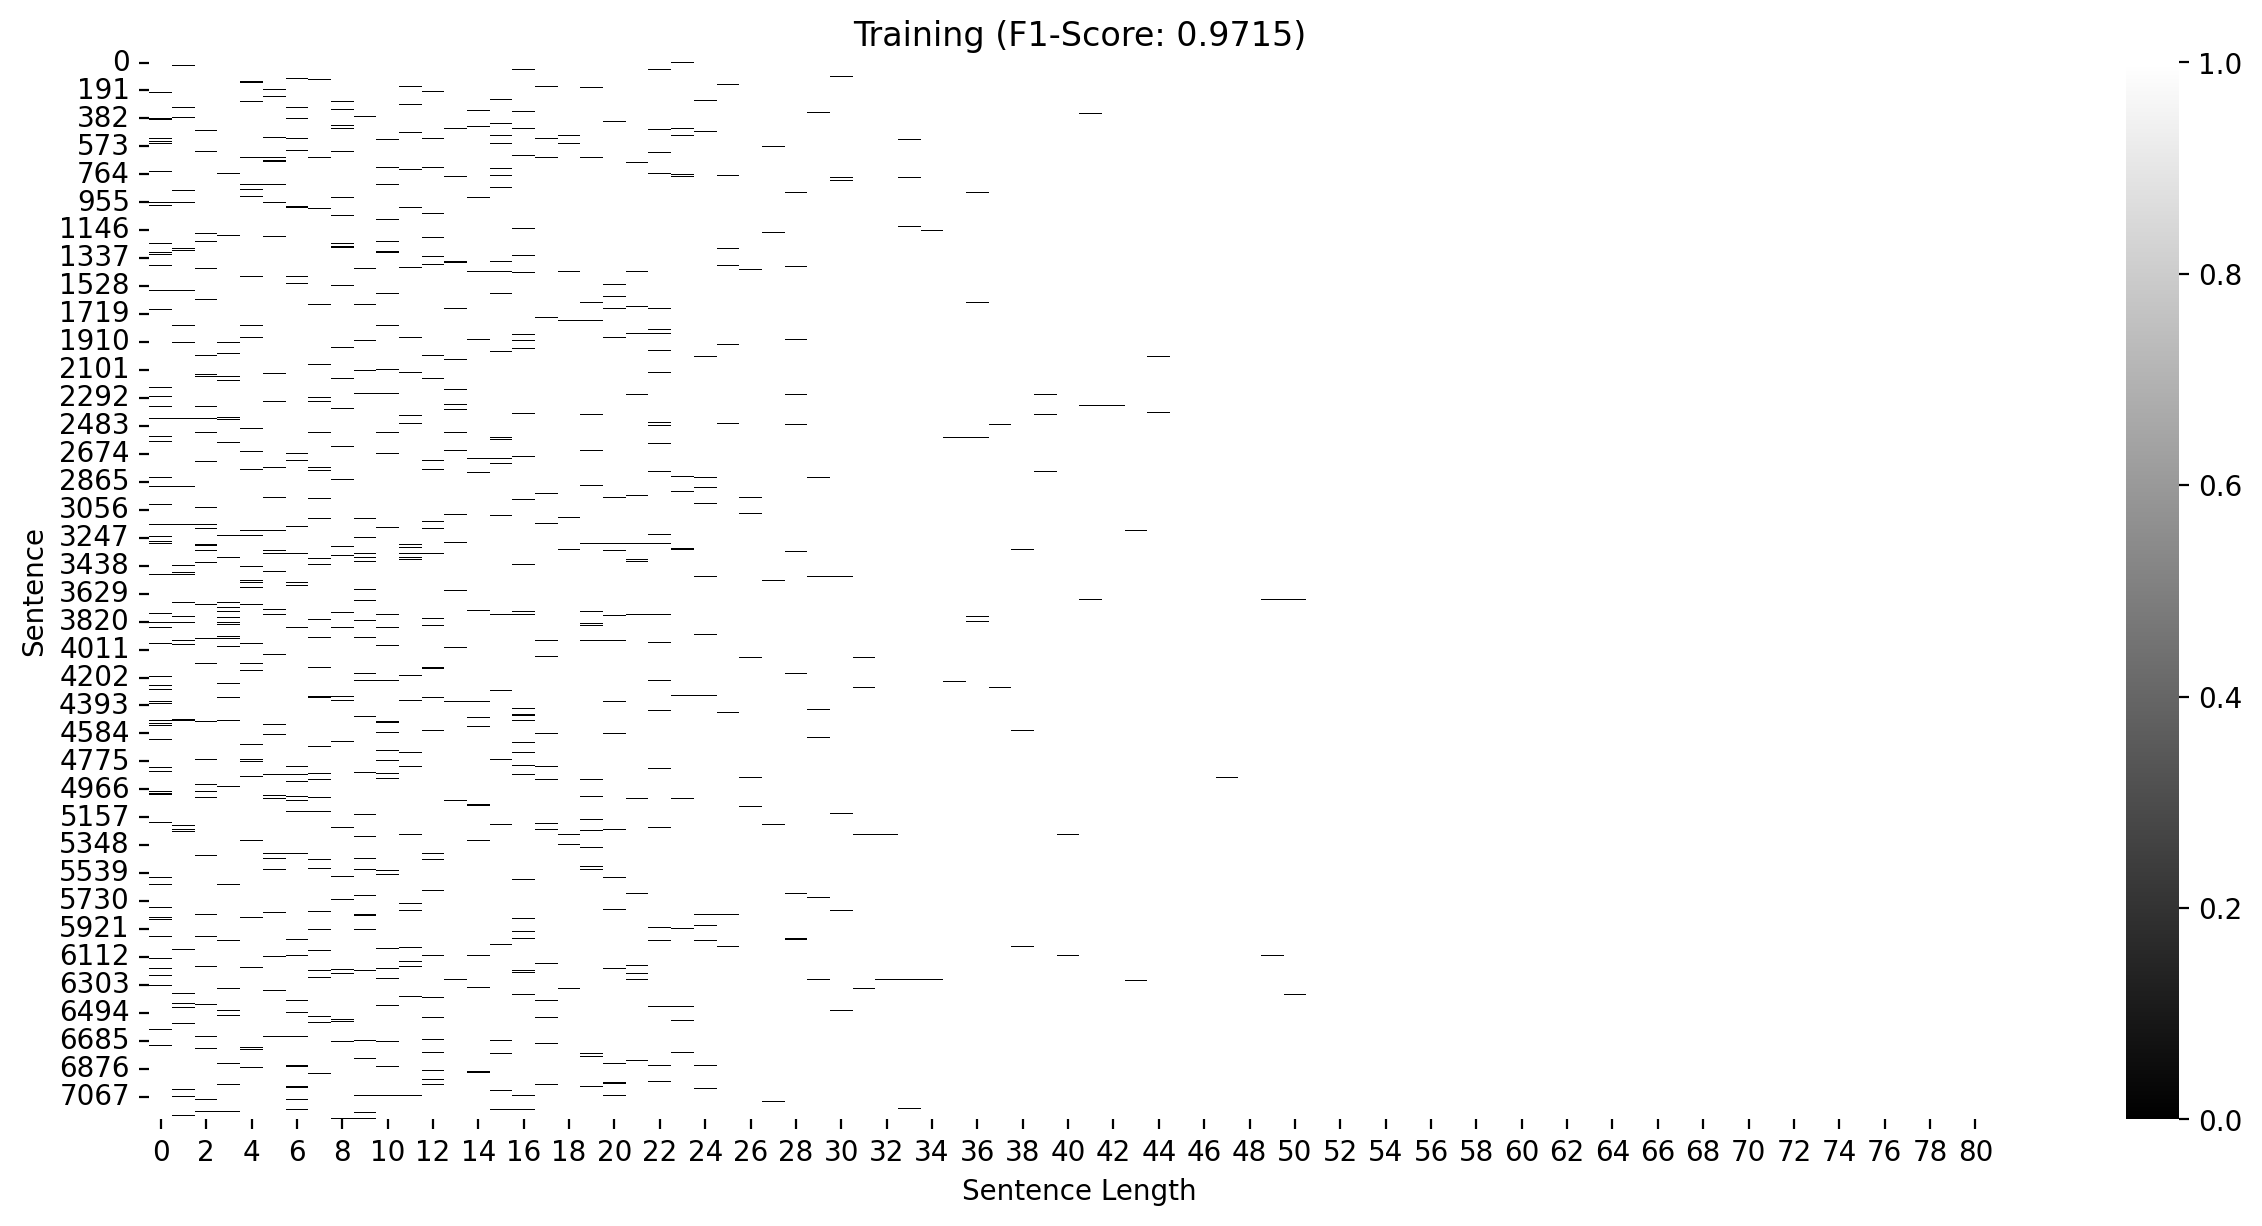

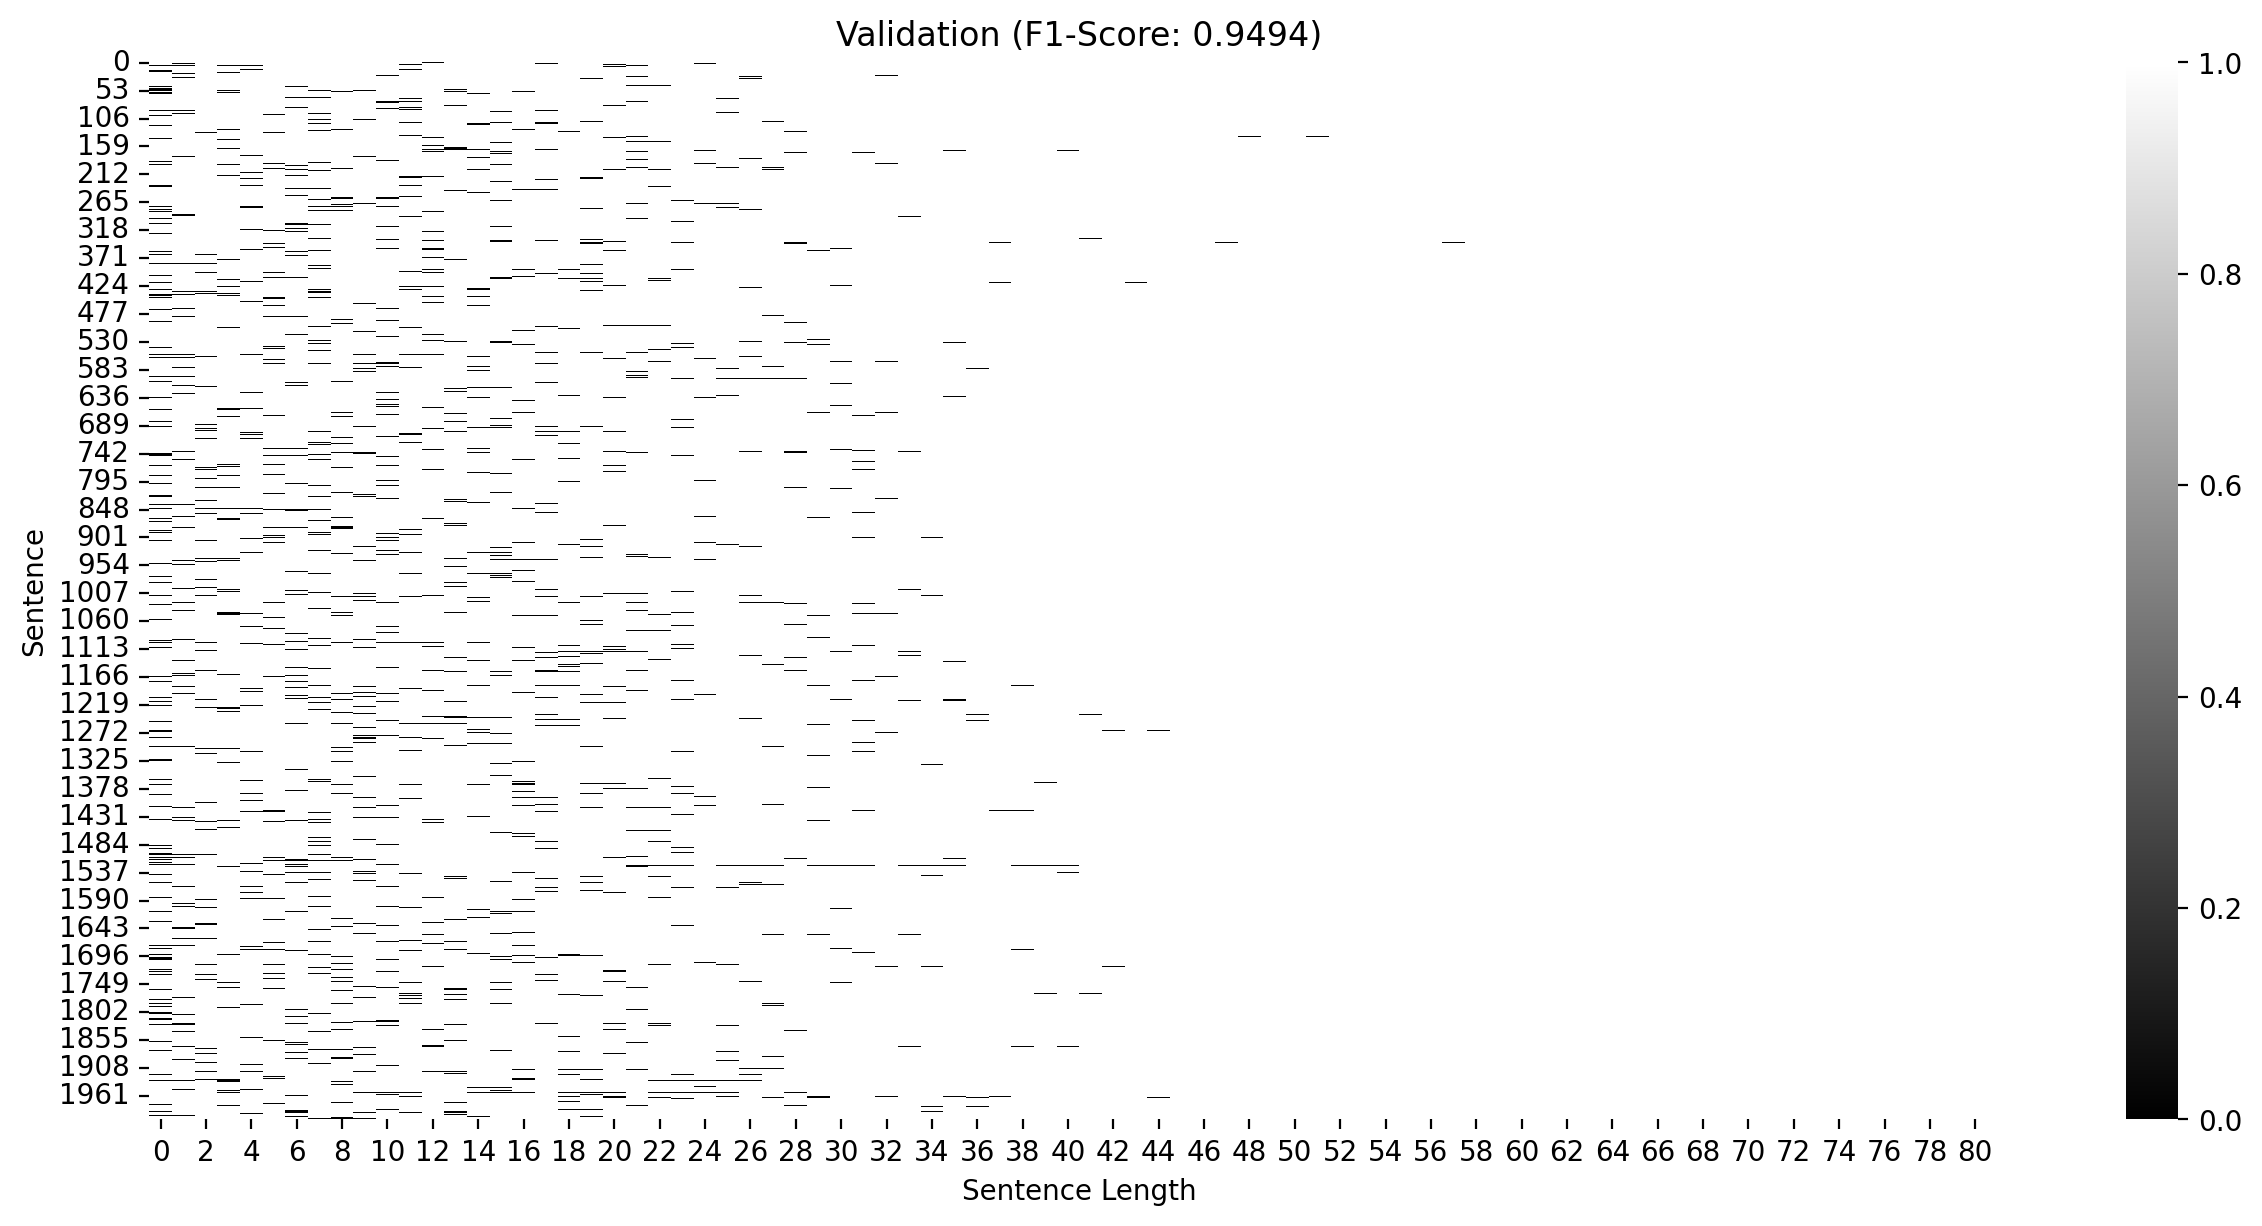

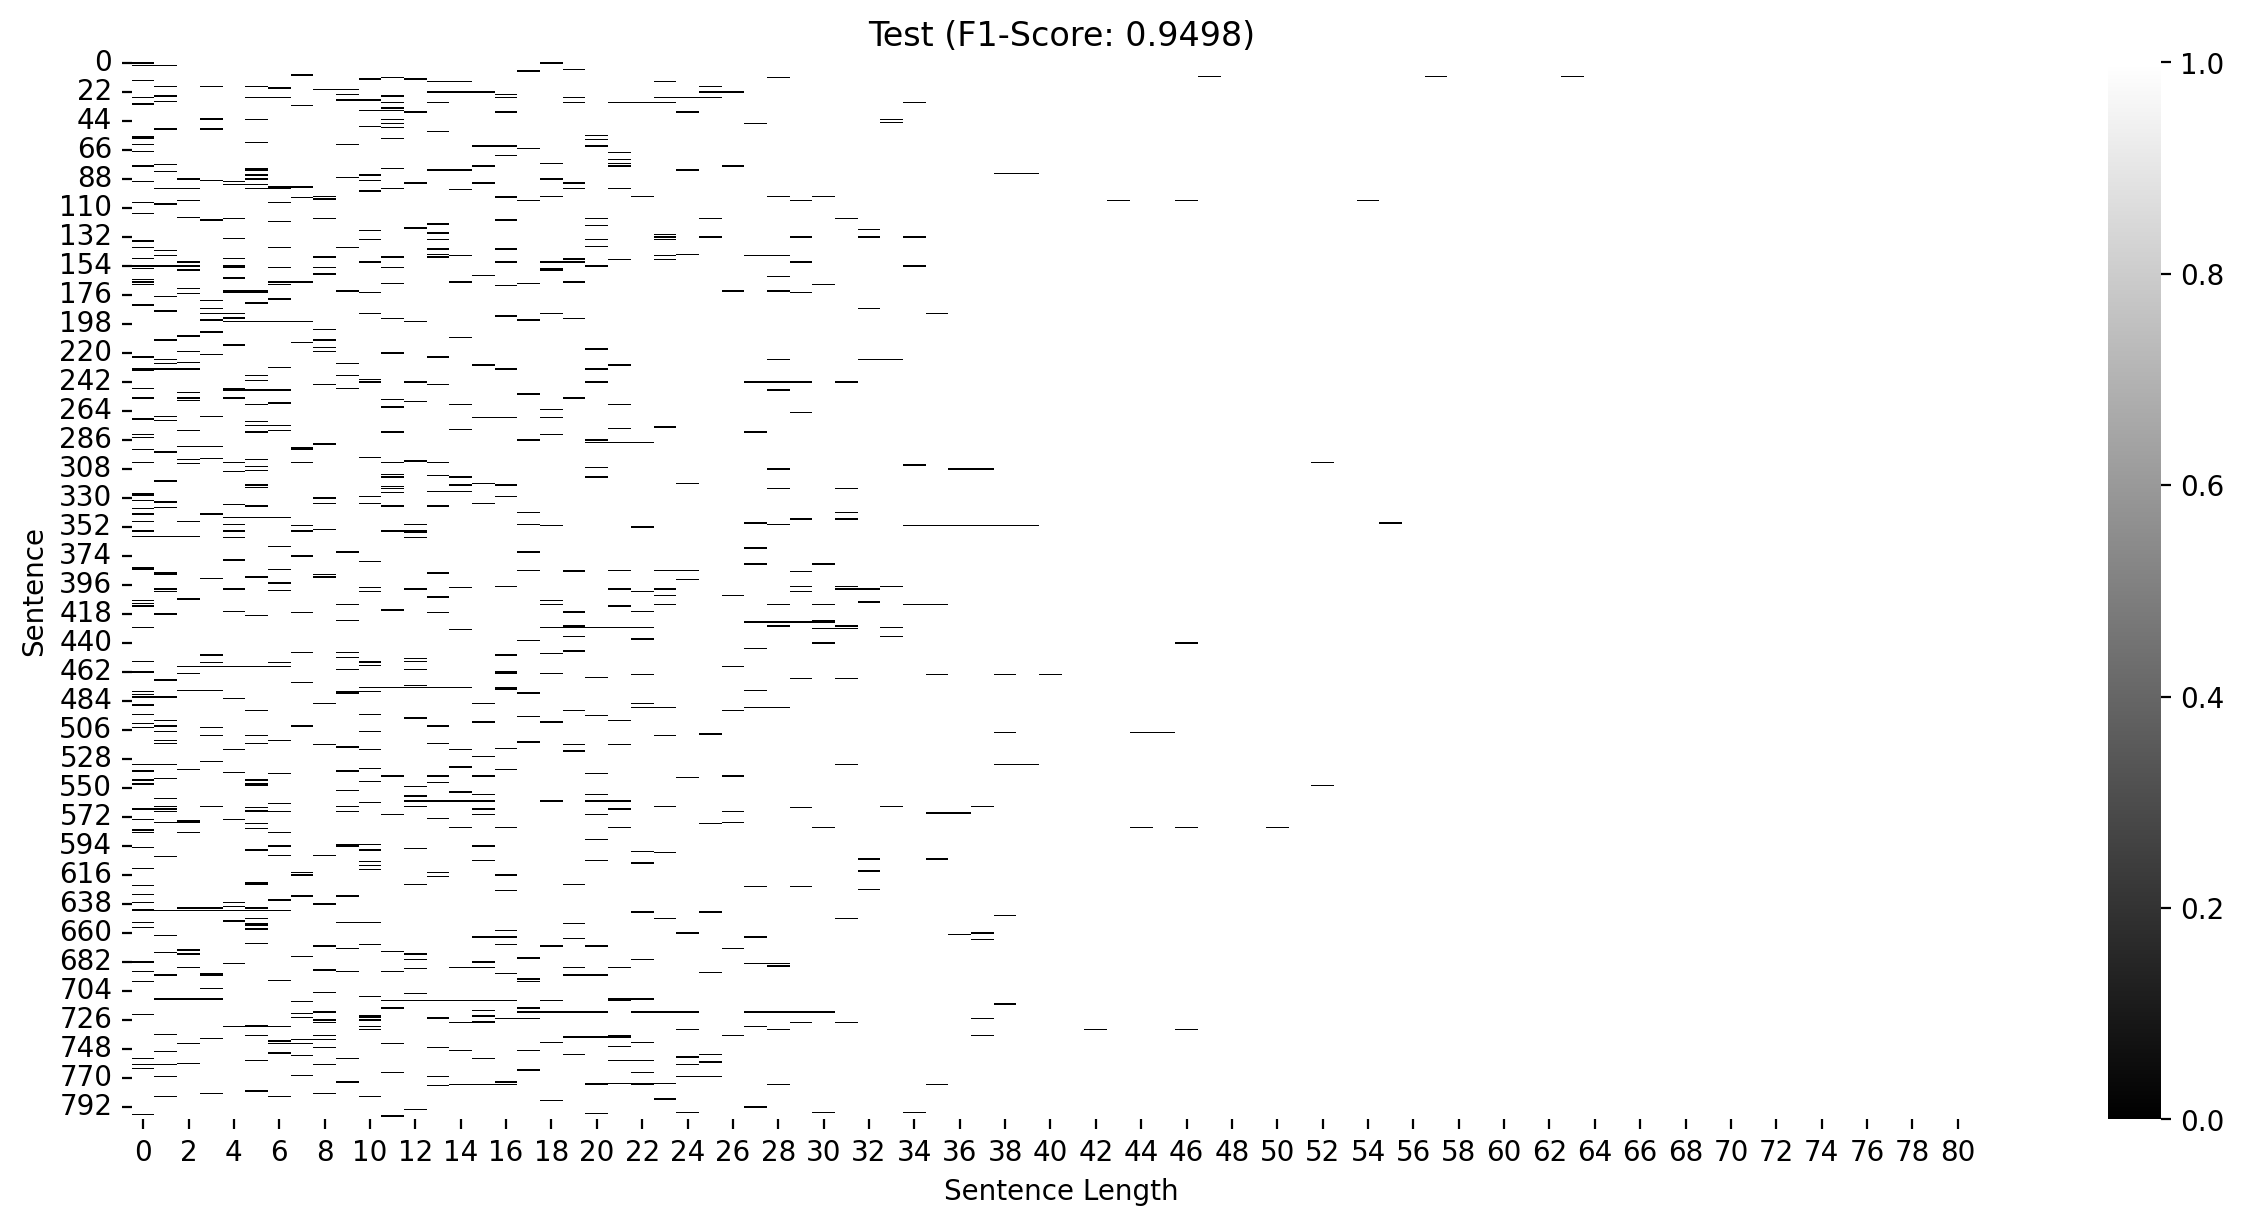

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


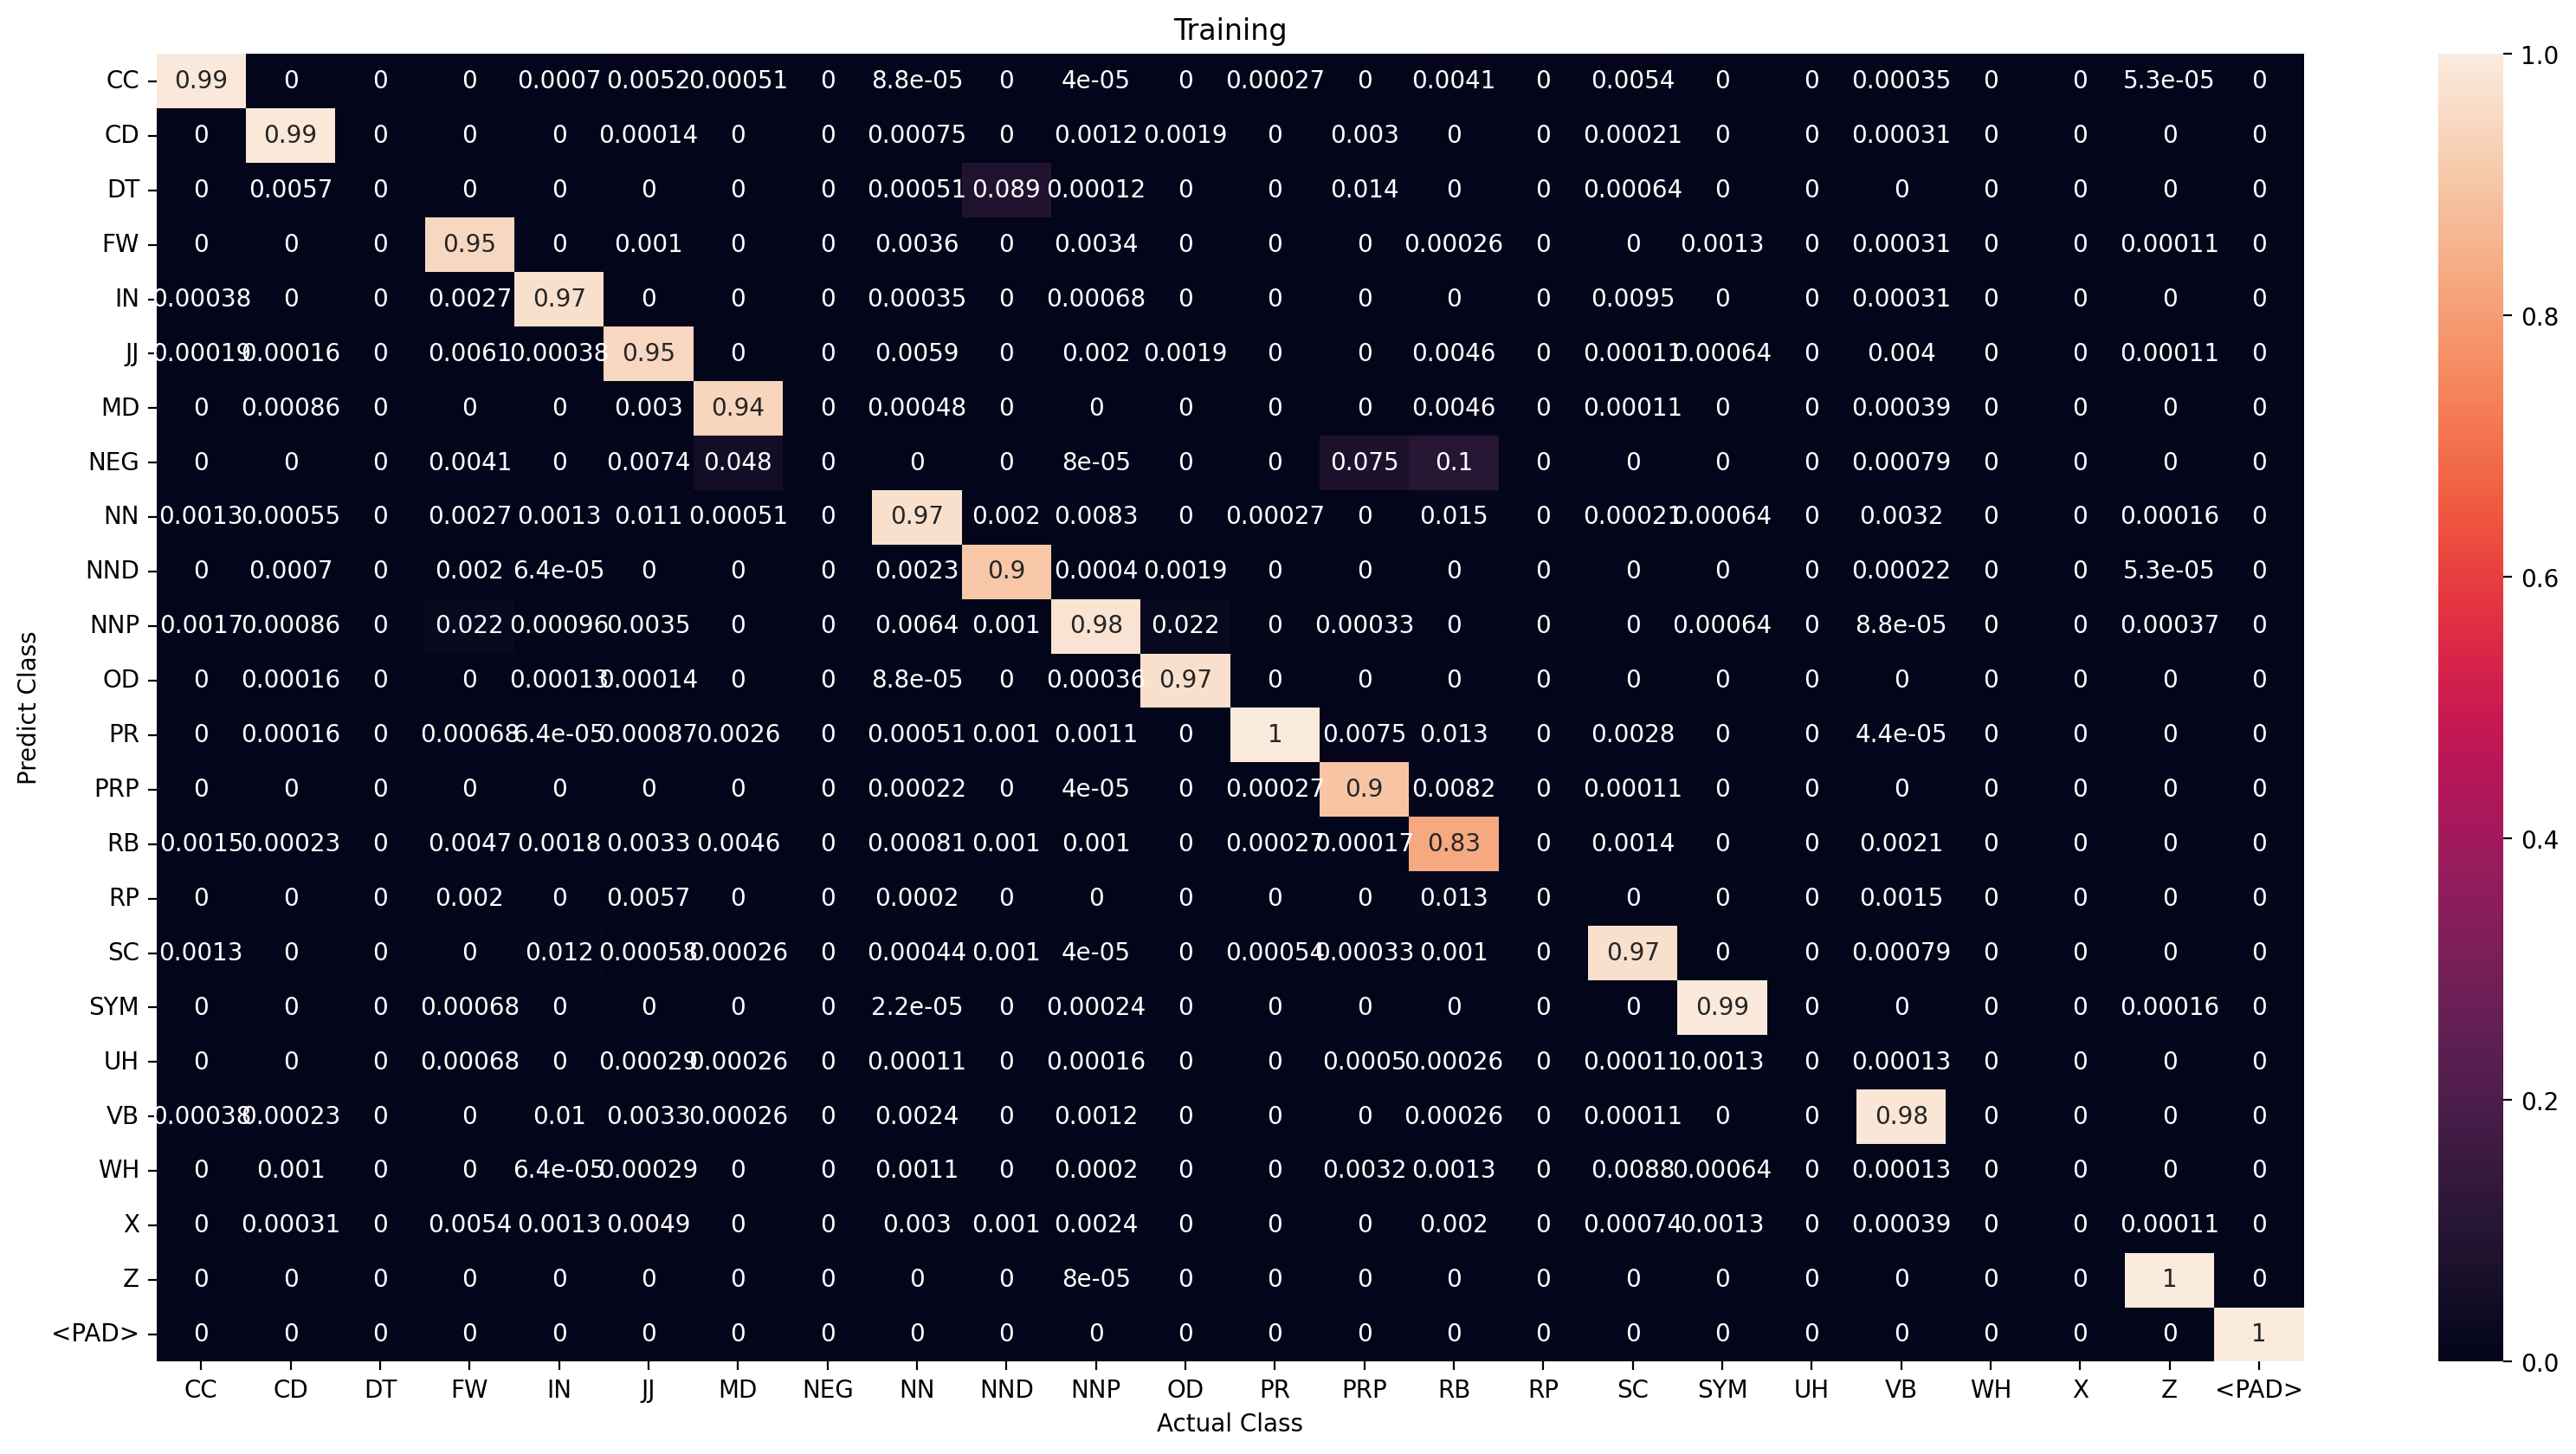

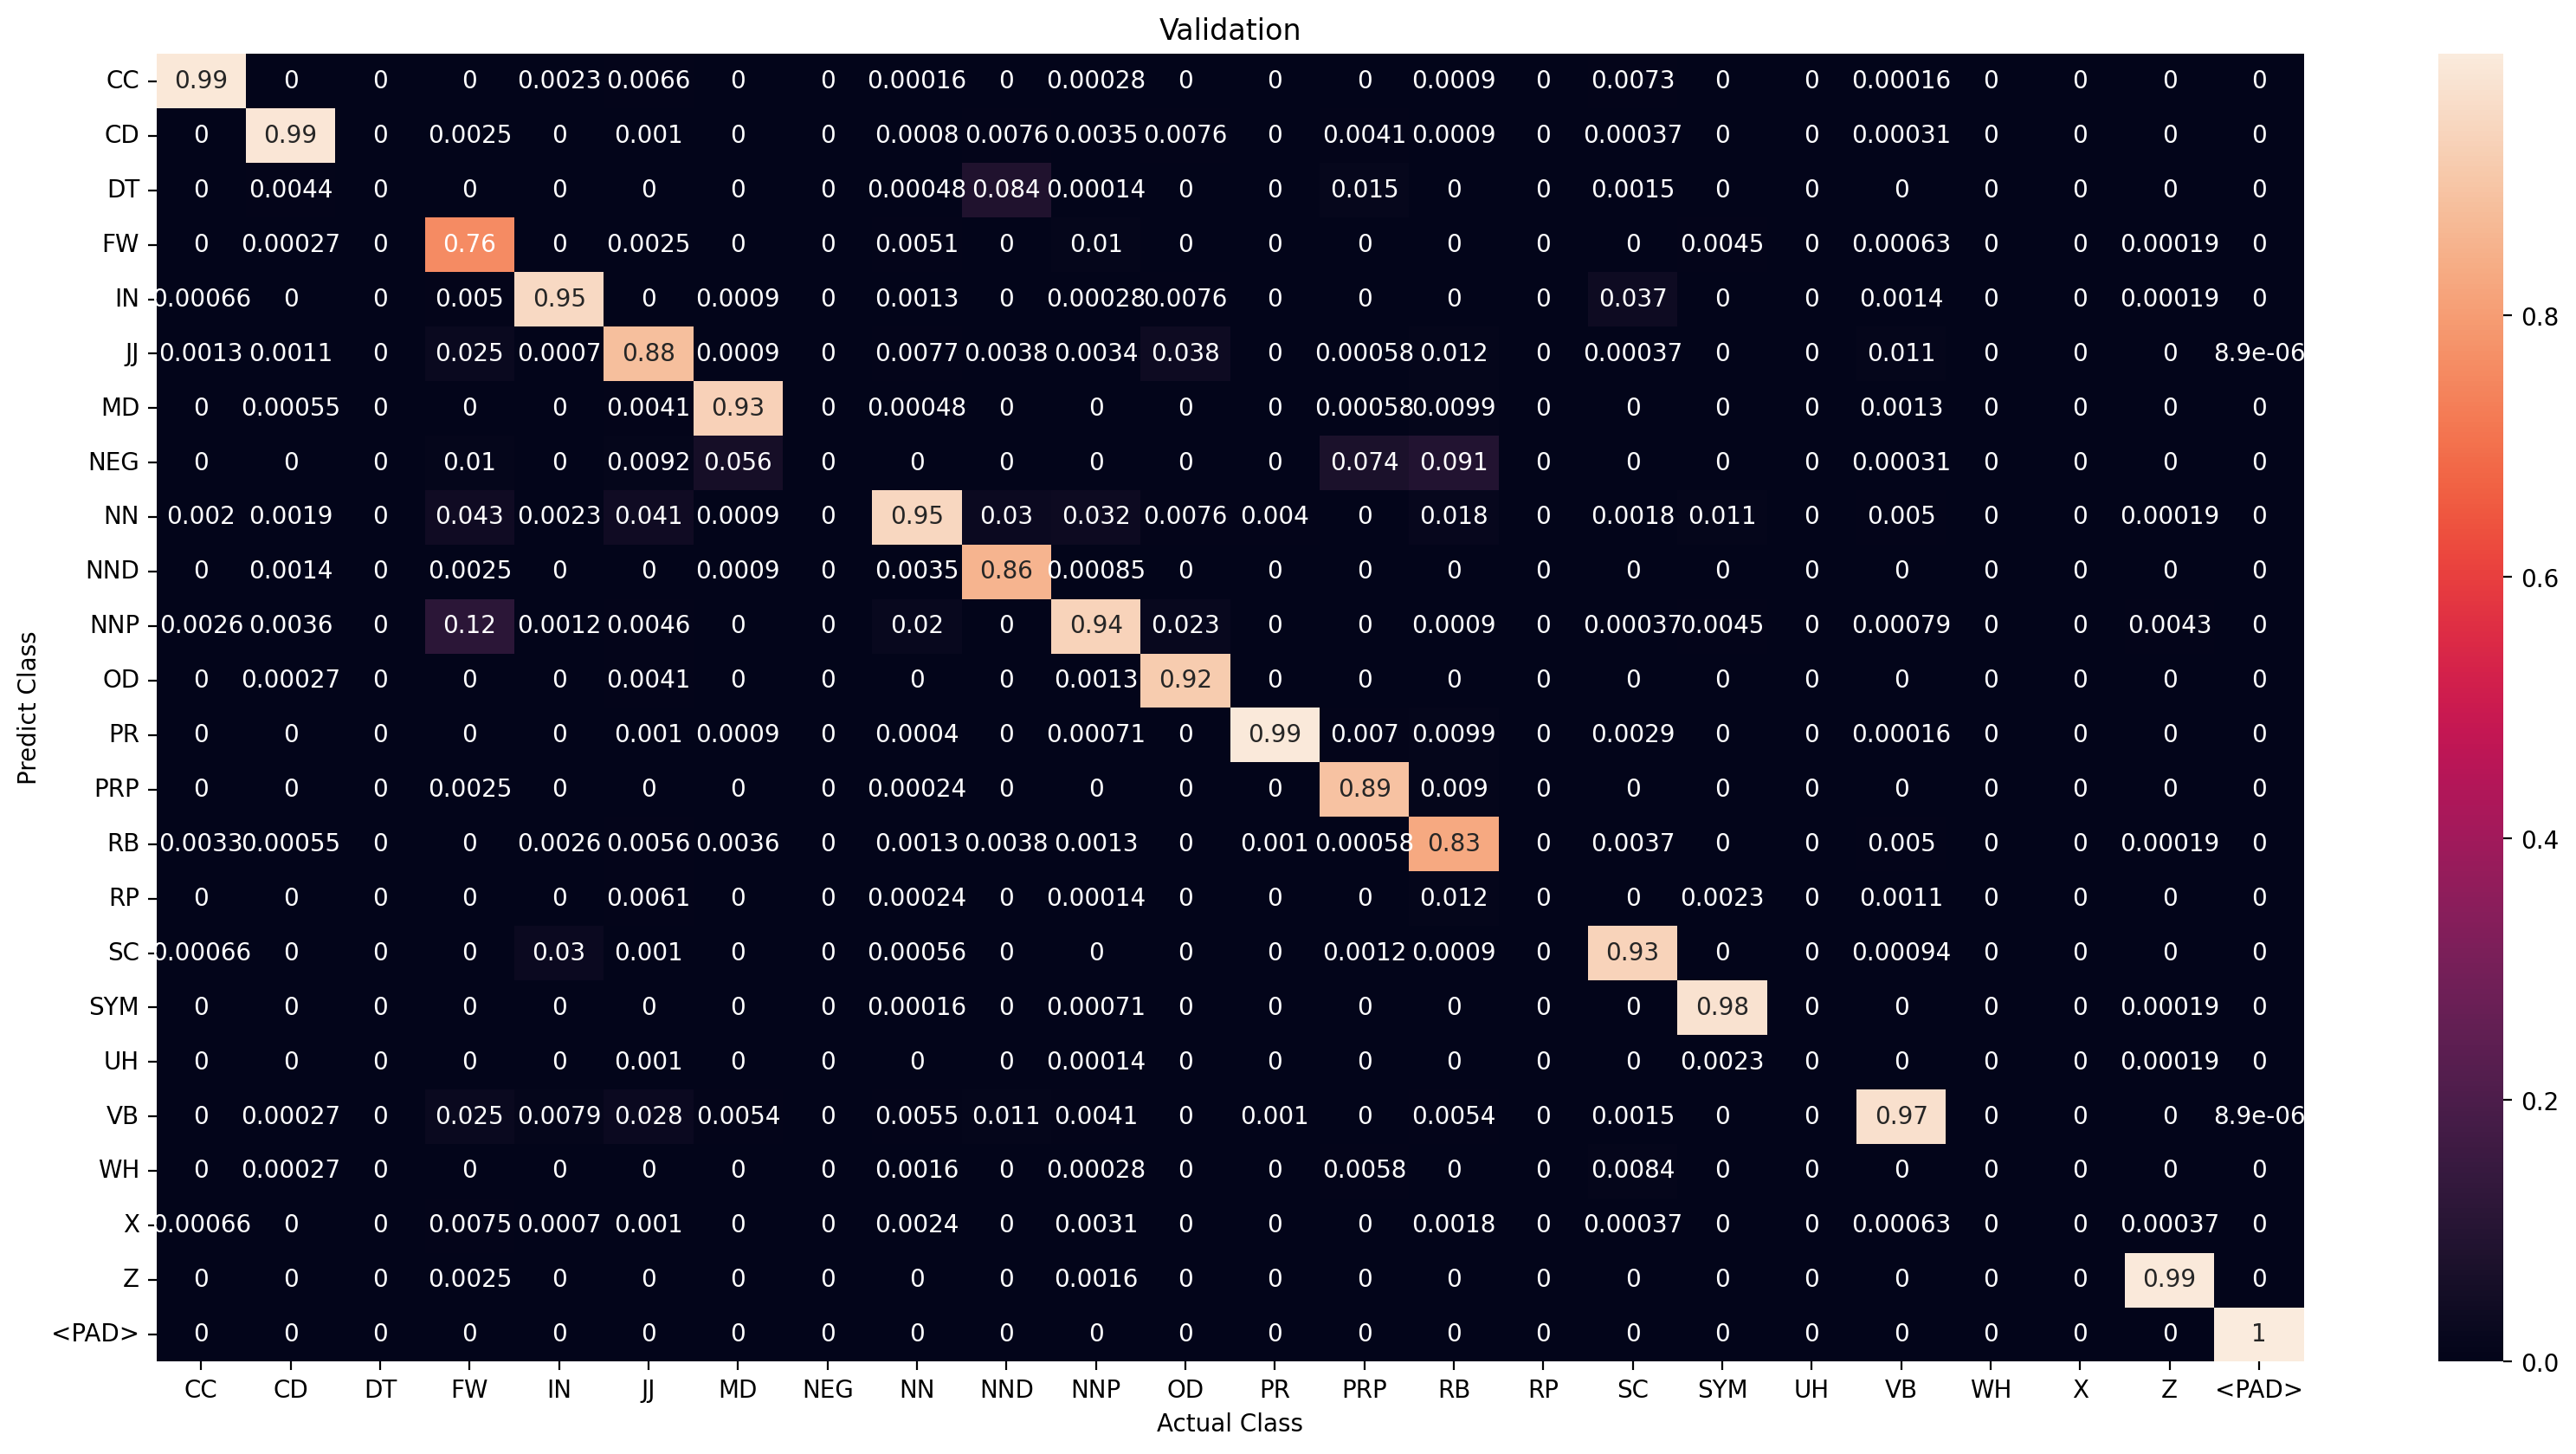

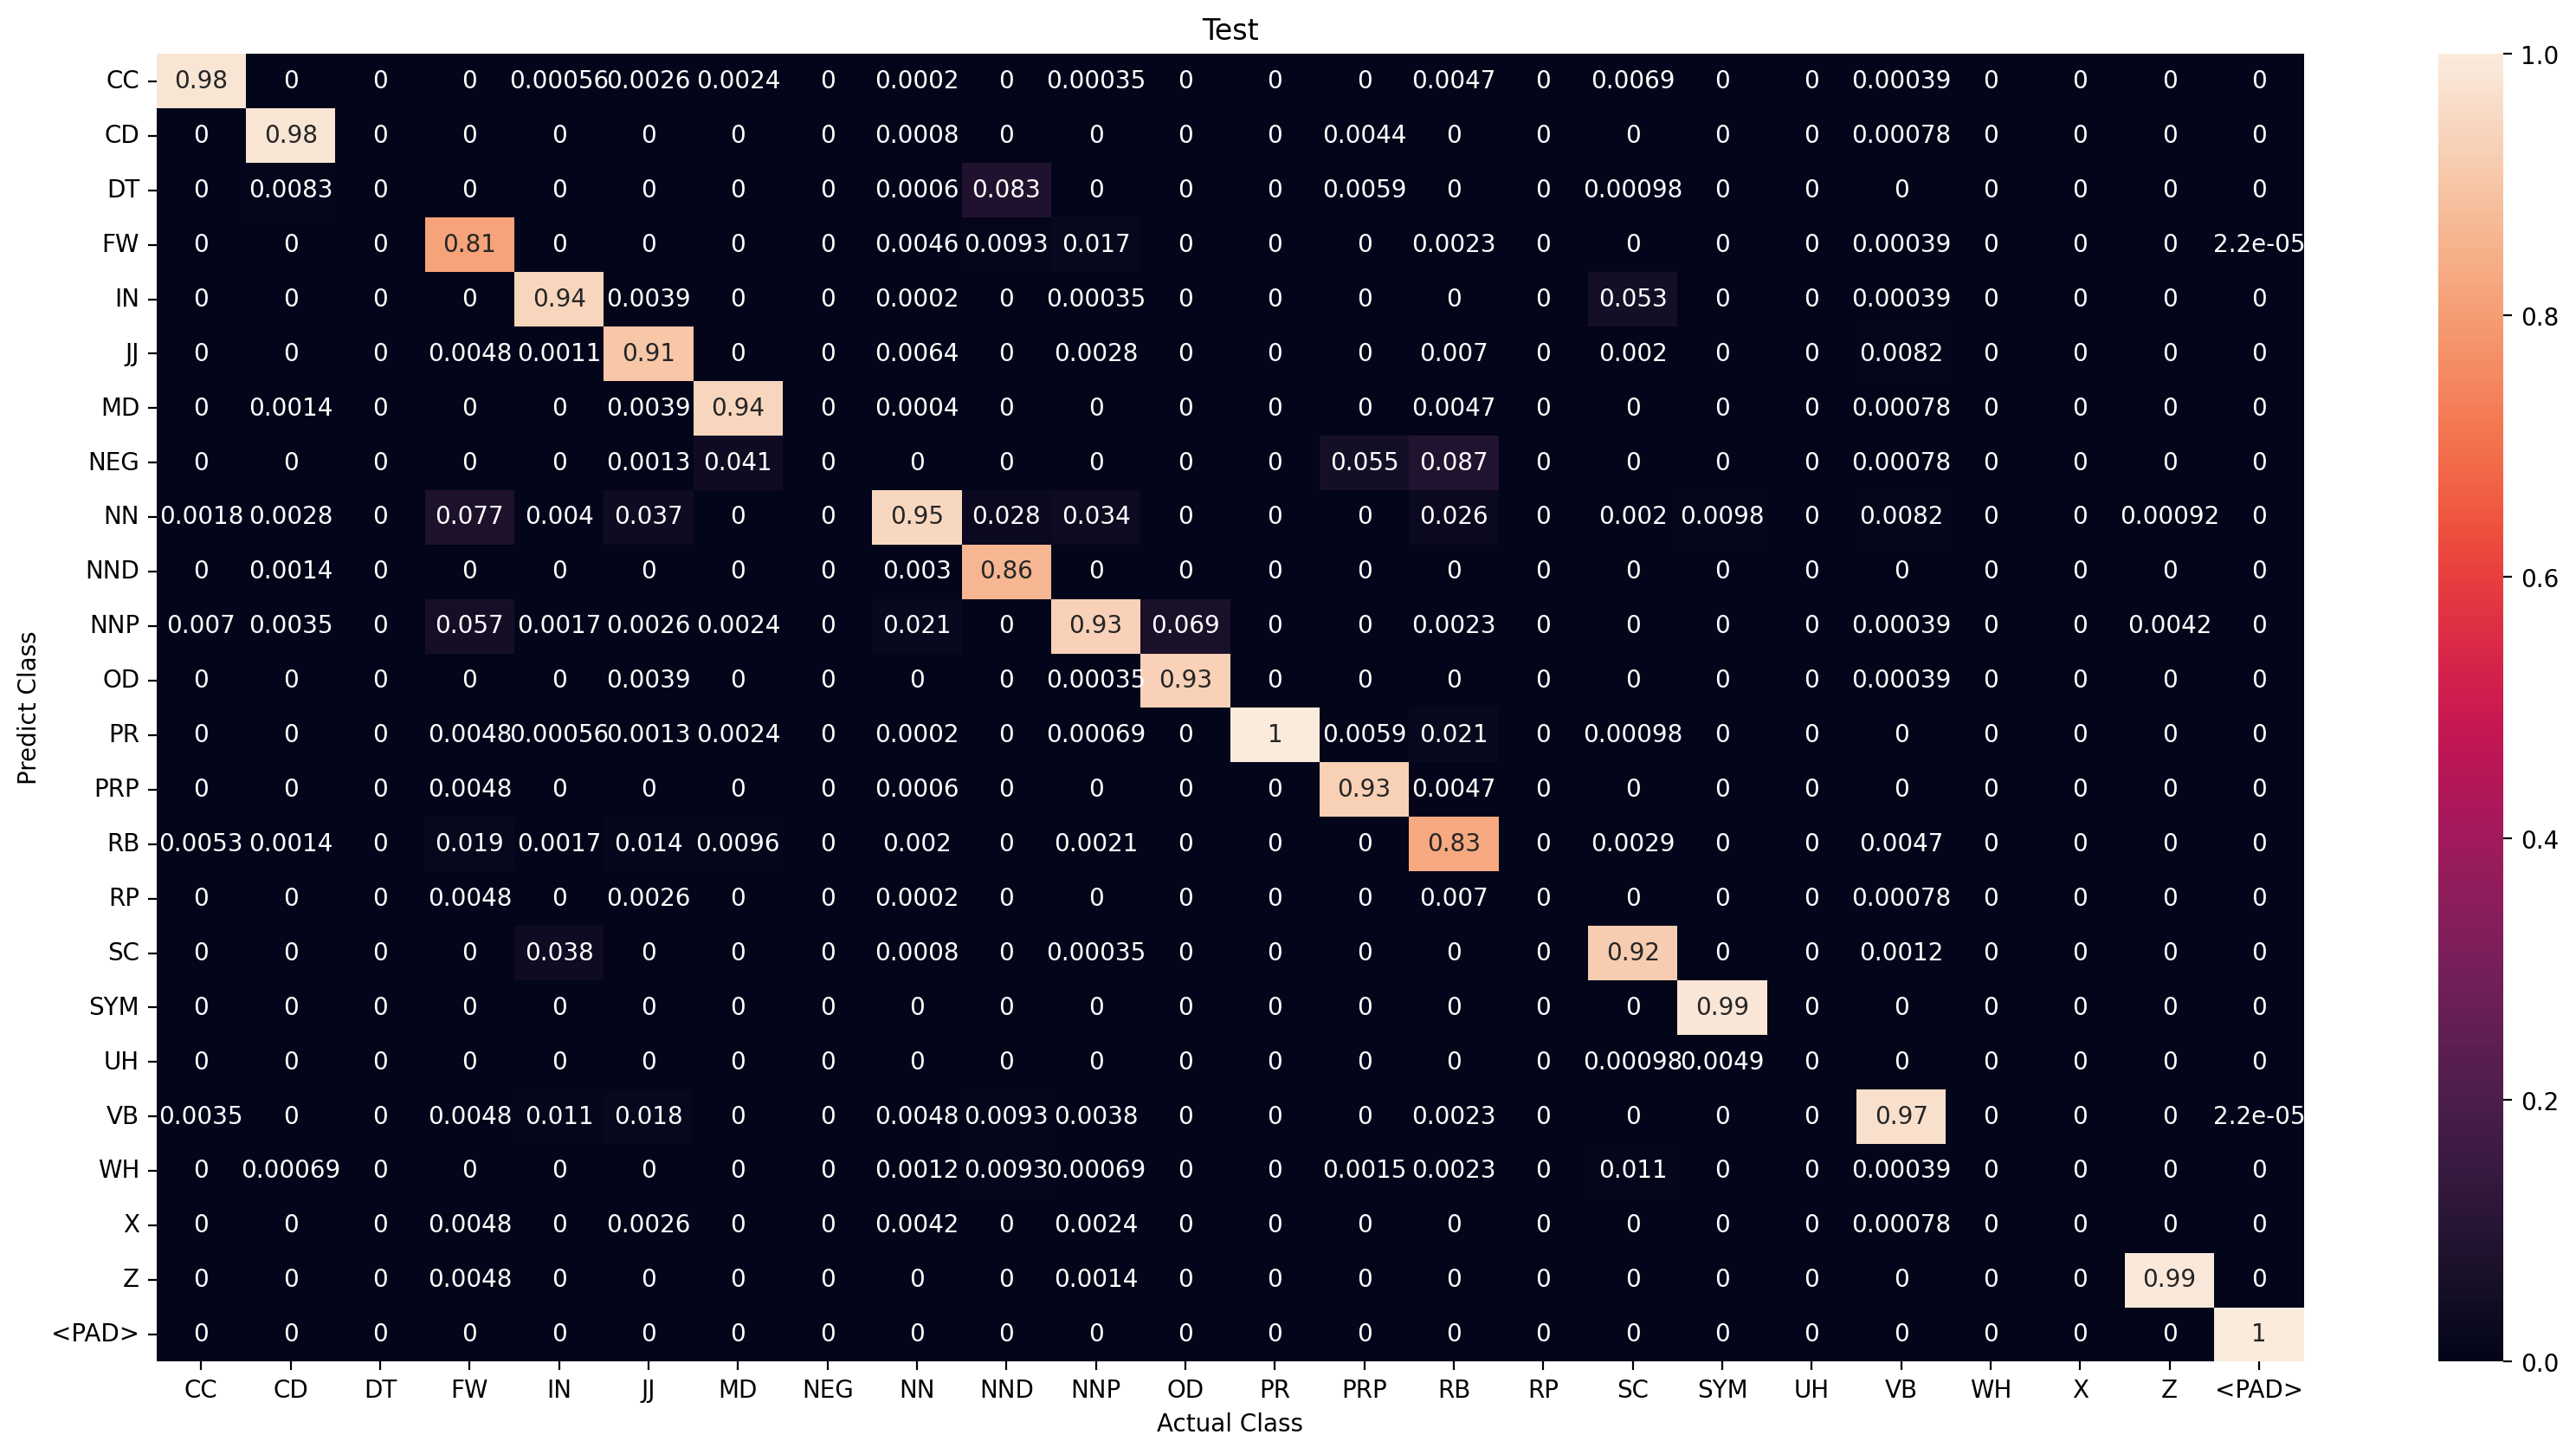

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5322   | CC    : 5191       | CC    : 131      |
| CD    : 12758  | CD    : 12666      | CD    : 92       |
| DT    : 277    | DT    : 0          | DT    : 277      |
| FW    : 1666   | FW    : 1398       | FW    : 268      |
| IN    : 15371  | IN    : 15236      | IN    : 135      |
| JJ    : 6997   | JJ    : 6544       | JJ    : 453      |
| MD    : 3774   | MD    : 3692       | MD    : 82       |
| NEG   : 1113   | NEG   : 0          | NEG   : 1113     |
| NN    : 44672  | NN    : 44205      | NN    : 467      |
| NND   : 1021   | NND   : 887        | NND   : 134      |
| NNP   : 24845  | NNP   : 24438      | NNP   : 407      |
| OD    : 541    | OD    : 523        | OD    : 18       |
| PR    : 3896   | PR    : 3703       | PR    : 193      |
| PRP   : 5408   | PRP   : 5363       | PRP   : 45       |
| RB    : 3463   | RB    : 3249       | RB    : 214      |
| RP    : 137    | RP    : 0          | RP    : 137     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11821
Correct prediction          : 11051
Wrong prediction            : 770
Percentage correct oov pred : 93.48616868285255

Validation
Number OOV token            : 3350
Correct prediction          : 2959
Wrong prediction            : 391
Percentage correct oov pred : 88.32835820895522

Test
Number OOV token            : 1391
Correct prediction          : 1245
Wrong prediction            : 146
Percentage correct oov pred : 89.5039539899353



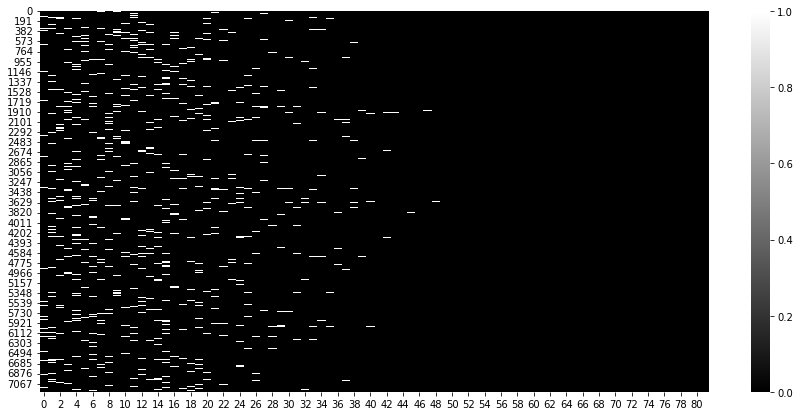

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

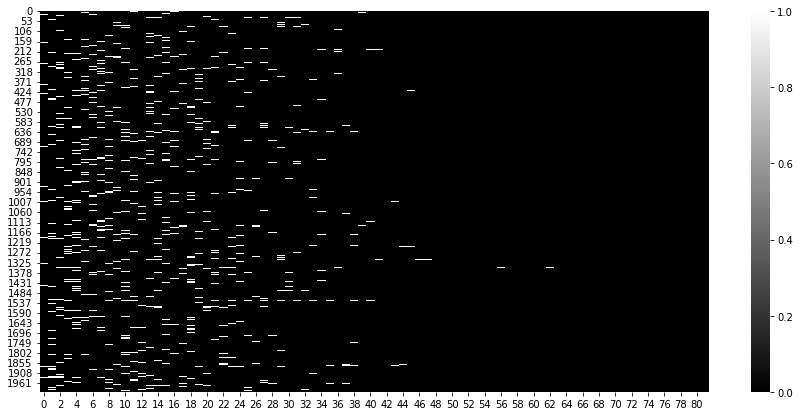

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

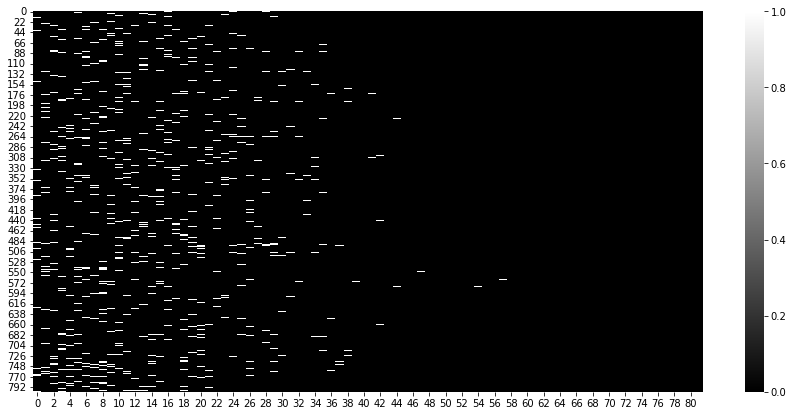

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);